# ResNet 구현하기

# 1. 라이브러리 로드

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2.데이터셋 준비

## 2.1 32x32 CIFAR_10 Dataset

In [58]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [59]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [60]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


## 2.2 224x224 Imagenet Dataset

In [6]:
BATCH_SIZE = 64
EPOCH = 30

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# create a new generator
imagegen = ImageDataGenerator()
# load train data
train_244 = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=BATCH_SIZE, target_size=(224, 224))
# load val data
test_244 = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=True, batch_size=BATCH_SIZE, target_size=(224, 224))

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


## 2.3 32x32데이터 normalize

In [76]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [77]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        lambda image, label: normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [82]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

# 2. 네트워크

## 2.1. VGG Net

In [10]:
def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [11]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

## 2.3 Residual & Plain Net


In [12]:
def build_res_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    is_plain=False,
                    is_50=False):
    x = input_layer
    for cnn_num in range(num_cnn):
        strides_num = 1
        if cnn_num == 0 and block_num != 0:
            strides_num = 2
        else:
            strides_num = 1
        #print(f'stage{block_num}_{cnn_num}_strides:{strides_num}, channel:{channel}')
        #첫번째 컨볼루션 레이어
        if is_50:
            fx = fx = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(1,1),
                strides=strides_num,
                kernel_initializer='he_normal',
                padding='same',
                name=f'Stage{block_num+2}_L_{cnn_num+1}_Conv{cnn_num+1}_1x1{channel}'
            )(x)
            fx = keras.layers.BatchNormalization(
                epsilon=1e-3, 
                momentum=0.999, 
                name=f'stage{block_num+2}_L_{cnn_num+1}_bn{cnn_num}'
            )(fx)
            fx = keras.layers.Activation(
                keras.activations.relu
            )(fx)
            fx = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides=1,
                kernel_initializer='he_normal',
                padding='same',
                name=f'Stage{block_num+2}_L_{cnn_num+1}_Conv{cnn_num+2}_3x3_{channel}'
            )(fx)
            fx = keras.layers.BatchNormalization(
                epsilon=1e-3, 
                momentum=0.999, 
                name=f'stage{block_num+2}_L_{cnn_num+1}_bn{cnn_num+1}'
            )(fx)
            fx = keras.layers.Activation(
                keras.activations.relu
            )(fx)
            fx = fx = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                strides=1,
                kernel_initializer='he_normal',
                padding='same',
                name=f'Stage{block_num+2}_L_{cnn_num+1}_Conv{cnn_num+3}_1x1_{channel}'
            )(fx)
            fx = keras.layers.BatchNormalization(
                epsilon=1e-3, 
                momentum=0.999, 
                name=f'stage{block_num+2}_L_{cnn_num+1}_bn{cnn_num+2}'
            )(fx)
            
            #차원조절
            if x.shape.as_list()[-1] != fx.shape.as_list()[-1]:
                #print('차원조절')
                #print(x.shape.as_list()[-1], fx.shape.as_list()[-1])
                x = keras.layers.Conv2D(filters=fx.shape.as_list()[-1], 
                                        kernel_size=(1), 
                                        strides=(strides_num), 
                                        padding="same",
                                        name=f'stage{block_num+2}_L_{cnn_num+1}_Prj{cnn_num}-{cnn_num+2}')(x)

            #Residual
            if is_plain == False:
                fx = keras.layers.Add(name=f'stage{block_num+2}_L_{cnn_num+1}_Add')([fx,x])
            #액티베이션 레이어
            x = keras.layers.Activation(keras.activations.relu)(fx)
            
        else:
            fx = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides=strides_num,
                kernel_initializer='he_normal',
                padding='same',
                name=f'Stage{block_num+2}_{cnn_num+1}_Conv{cnn_num}_3x3_{channel}'
            )(x)
            #두번째 배치 레이어
            fx = keras.layers.BatchNormalization(
                epsilon=1e-3, 
                momentum=0.999, 
                name=f'stage{block_num+2}_{cnn_num+1}_bn{cnn_num}'
            )(fx)
            #액티베이션 레이어
            fx = keras.layers.Activation(
                keras.activations.relu
            )(fx)
            #두번째 컨볼루션 레이어
            fx = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'Stage{block_num+2}_{cnn_num+1}_Conv{cnn_num+1}_3x3_{channel}'
            )(fx)
            #두번째 배치 레이어
            fx = keras.layers.BatchNormalization(
                epsilon=1e-3, 
                momentum=0.999, 
                name=f'stage{block_num+2}_{cnn_num+1}_bn{cnn_num+1}'
            )(fx)
            
            #차원조절
            if x.shape.as_list()[-1] != fx.shape.as_list()[-1]:
                #print('차원조절')
                #print(x.shape.as_list()[-1], fx.shape.as_list()[-1])
                x = keras.layers.Conv2D(filters=fx.shape.as_list()[-1], kernel_size=(1), strides=(strides_num), padding="same",name=f'stage{block_num+2}_conv{cnn_num}-{cnn_num+2}')(x)

            #Residual
            if is_plain == False:
                fx = keras.layers.Add(name=f'stage{block_num+2}_{cnn_num+1}_Add')([fx,x])
            #액티베이션 레이어
            x = keras.layers.Activation(keras.activations.relu)(fx)
    return x

## 3.2 Resdual & Plain Net Build

In [13]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,
              is_plain=False,
              is_50=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    #Cov1 레이어는 
    output = keras.layers.Conv2D(
        filters=64,
        strides=2,
        kernel_size=(7,7),
        kernel_initializer='he_normal',
        padding='same',
        name='stage1_conv1'
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation(keras.activations.relu)(output)
    #맥스풀링 레이어
    output = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name='block0_maxpooling'
    )(output)
        
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        #print(i, num_cnn)
        output = build_res_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50,
            is_plain=is_plain
        )
    output = keras.layers.GlobalAveragePooling2D()(output)        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

# 4.Test

## 4.1 resnet50

In [15]:
resnet_50 = build_resnet(input_shape=(224, 224,3), 
                               num_cnn_list=[3,4,6,3],
                               channel_list=[64,128,256,512],
                               is_plain=False,
                               is_50=True)
resnet_50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv1 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         stage1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.011, clipnorm=1. ,decay=0.0001, momentum=0.9),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### Keras.ResNet50
직접 만들어본 resnet의 성능 검증을 위해 keras에 내장된 resnet50 도 학습시켜 봅니다.

In [18]:
tf_resnet_50 = keras.applications.ResNet50(weights=None, input_shape=(224, 224, 3), include_top=True, pooling='max', classes=10, classifier_activation="softmax",)
tf_resnet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
tf_resnet_50.compile(
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.SGD(lr=0.011, clipnorm=1. ,decay=0.0001, momentum=0.9)) 

### 직접 만들어본 Resnet34 Layer

In [21]:
resnet_34 = build_resnet(input_shape=(224, 224,3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv1 (Conv2D)           (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         stage1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, clipnorm=1. ,decay=0.0001, momentum=0.9),
    metrics=['accuracy'],
)

## Plain50

In [23]:
plain_50 = build_resnet(input_shape=(224, 224,3), 
                               num_cnn_list=[3,4,6,3],
                               channel_list=[64,128,256,512],
                               is_plain=True,
                               is_50=True)
plain_50.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv1 (Conv2D)        (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_33 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
block0_maxpooling (MaxPoolin (None, 56, 56, 64)        0         
_________________________________________________________________
Stage2_L_1_Conv1_1x164 (Conv (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_L_1_bn0 (BatchNormali (None, 56, 56, 64)        256 

In [24]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.011, clipnorm=1. ,decay=0.0001, momentum=0.9),
    metrics=['accuracy'],
)

In [25]:
plain_34 = build_resnet(input_shape=(224, 224,3), 
                               is_plain=True,
                               is_50=False)
plain_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv1 (Conv2D)        (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
block0_maxpooling (MaxPoolin (None, 56, 56, 64)        0         
_________________________________________________________________
Stage2_1_Conv0_3x3_64 (Conv2 (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn0 (BatchNormaliza (None, 56, 56, 64)        256 

In [26]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.011, clipnorm=1. ,decay=0.0001, momentum=0.9),
    metrics=['accuracy'],
)

## VGGNet

In [27]:
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [97]:
vgg_224_16 = build_vgg(input_shape=(224,224,3))

vgg_224_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)       0   

In [28]:
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)
vgg_19.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [98]:
vgg_224_19 = build_vgg(
    input_shape=(224,224,3),
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_224_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)       0   

In [29]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [30]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [99]:
vgg_224_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [100]:
vgg_224_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

### resnet32 for CIFAR-10
resnet의 레이어는 매우 깊기 때문에 CIFAR-10의 작은 이미지를 학습하면 오버피팅이 발생하였다.
그래서 논문에 나와있는 CIFAR-10 전용 resnet 네트워크를 구성하여 테스트 해보았다.

In [86]:
resnet_cifar_10 = build_resnet(input_shape=(32, 32,3), 
                               num_cnn_list=[4,4,4],
                               channel_list=[16,32,64], 
                               is_50=False)
resnet_cifar_10.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv1 (Conv2D)           (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         stage1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [87]:
resnet_cifar_10.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1. ,decay=0.0001, momentum=0.9),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# 5. Training


Imagenette 데이터셋 224x224 사이즈  
Resnet 34,50 Plain 34,50 VGG 16,19 모델을 학습  
tf_resnet50은 keras에 내장되어 있는 모델로   
위에서 구현한 resnet과 성능을 참고하기 위해 총 7개의 모델 학습을 진행하였다.

In [35]:
history_50 = resnet_50.fit_generator(train_244, epochs=30, validation_data=test_244, use_multiprocessing=True)
tf.keras.backend.clear_session()
tf_res_history_50 = tf_resnet_50.fit(train_244, epochs=30, validation_data=test_244, use_multiprocessing=True,)
tf.keras.backend.clear_session()
history_res_34 = resnet_34.fit(train_244, epochs=30, validation_data=test_244, use_multiprocessing=True)
tf.keras.backend.clear_session()
history_plain_34 = plain_34.fit(train_244, epochs=30, validation_data=test_244, use_multiprocessing=True)
tf.keras.backend.clear_session()
history_plain_50 = plain_50.fit(train_244, epochs=30, validation_data=test_244, use_multiprocessing=True)
tf.keras.backend.clear_session()

/opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
148/148 [==============================] - 339s 2s/step - loss: 2.1940 - accuracy: 0.2835 - val_loss: 17894.4160 - val_accuracy: 0.1068
Epoch 2/30
148/148 [==============================] - 132s 888ms/step - loss: 1.6635 - accuracy: 0.4531 - val_loss: 2965.6746 - val_accuracy: 0.1006
Epoch 3/30
148/148 [==============================] - 132s 889ms/step - loss: 1.3288 - accuracy: 0.5700 - val_loss: 264.2224 - val_accuracy: 0.1006
Epoch 4/30
148/148 [==============================] - 131s 886ms/step - loss: 1.0908 - accuracy: 0.6484 - val_loss: 72.0460 - val_accuracy: 0.1205
Epoch 5/30
148/148 [==============================] - 131s 885ms/step - loss: 0.9177 - accuracy: 0.7079 - val_loss: 49.8958 - val_accuracy: 0.1039
Epoch 6/30
148/148 [==============================] - 132s 888ms/step - loss: 0.7876 - accuracy: 0.7438 - val_loss: 18.7956 - val_accuracy: 0.1027
Epoch 7/30
148/148 [==============================] - 131s 881ms/step - loss: 0.6615 - accuracy: 0.7846 - val_loss:

##  VGG16,19 

In [83]:
history_vgg_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
history_vgg_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
781/781 [==============================] - 49s 58ms/step - loss: 2.0224 - accuracy: 0.2492 - val_loss: 1.7857 - val_accuracy: 0.3523
Epoch 2/15
781/781 [==============================] - 43s 55ms/step - loss: 1.6848 - accuracy: 0.3888 - val_loss: 1.5908 - val_accuracy: 0.4351
Epoch 3/15
781/781 [==============================] - 44s 56ms/step - loss: 1.5252 - accuracy: 0.4488 - val_loss: 1.4320 - val_accuracy: 0.4803
Epoch 4/15
781/781 [==============================] - 44s 56ms/step - loss: 1.4019 - accuracy: 0.4941 - val_loss: 1.4490 - val_accuracy: 0.4741
Epoch 5/15
781/781 [==============================] - 44s 56ms/step - loss: 1.3062 - accuracy: 0.5308 - val_loss: 1.2281 - val_accuracy: 0.5710
Epoch 6/15
781/781 [==============================] - 43s 56ms/step - loss: 1.2065 - accuracy: 0.5698 - val_loss: 1.2447 - val_accuracy: 0.5541
Epoch 7/15
781/781 [==============================] - 43s 56ms/step - loss: 1.1291 - accuracy: 0.5972 - val_loss: 1.1545 - val_accuracy:

## resnet 26 cifar10

일반적인 resnet은 cifar10과 같은 작은 Input사이즈의 모델에서는 과적합이 일어나기 때문에 논문을 참고해 만들어 보았다.

In [88]:
history_resnet_cifar_10 = resnet_cifar_10.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
781/781 [==============================] - 29s 30ms/step - loss: 1.5552 - accuracy: 0.4363 - val_loss: 3.9766 - val_accuracy: 0.1841
Epoch 2/15
781/781 [==============================] - 23s 29ms/step - loss: 1.2390 - accuracy: 0.5548 - val_loss: 2.4897 - val_accuracy: 0.2959
Epoch 3/15
781/781 [==============================] - 22s 29ms/step - loss: 1.0931 - accuracy: 0.6115 - val_loss: 1.4878 - val_accuracy: 0.5084
Epoch 4/15
781/781 [==============================] - 22s 29ms/step - loss: 0.9935 - accuracy: 0.6494 - val_loss: 1.2301 - val_accuracy: 0.5759
Epoch 5/15
781/781 [==============================] - 23s 29ms/step - loss: 0.9093 - accuracy: 0.6779 - val_loss: 1.2387 - val_accuracy: 0.5750
Epoch 6/15
781/781 [==============================] - 22s 29ms/step - loss: 0.8365 - accuracy: 0.7047 - val_loss: 1.1103 - val_accuracy: 0.6191
Epoch 7/15
781/781 [==============================] - 23s 29ms/step - loss: 0.7670 - accuracy: 0.7279 - val_loss: 1.2114 - val_accuracy:

In [101]:
tf.keras.backend.clear_session()

In [102]:
history_vgg_224_19 = vgg_224_19.fit(train_244, epochs=30, validation_data=test_244, use_multiprocessing=True)
history_vgg_224_16 = vgg_224_16.fit(train_244, epochs=30, validation_data=test_244, use_multiprocessing=True)

Epoch 1/30
148/148 [==============================] - 239s 1s/step - loss: 14.8374 - accuracy: 0.1432 - val_loss: 2.4019 - val_accuracy: 0.1600
Epoch 2/30
148/148 [==============================] - 190s 1s/step - loss: 2.1576 - accuracy: 0.2516 - val_loss: 1.8915 - val_accuracy: 0.3243
Epoch 3/30
148/148 [==============================] - 189s 1s/step - loss: 1.9248 - accuracy: 0.3355 - val_loss: 1.8366 - val_accuracy: 0.3720
Epoch 4/30
148/148 [==============================] - 189s 1s/step - loss: 1.7641 - accuracy: 0.3894 - val_loss: 1.7122 - val_accuracy: 0.4191
Epoch 5/30
148/148 [==============================] - 190s 1s/step - loss: 1.6286 - accuracy: 0.4505 - val_loss: 1.6279 - val_accuracy: 0.4530
Epoch 6/30
148/148 [==============================] - 190s 1s/step - loss: 1.5276 - accuracy: 0.4873 - val_loss: 1.4660 - val_accuracy: 0.5175
Epoch 7/30
148/148 [==============================] - 189s 1s/step - loss: 1.4346 - accuracy: 0.5203 - val_loss: 1.4479 - val_accuracy: 0.520

# 6.시각화

In [129]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    if name == 'loss':
        plt.ylim(0, 25)
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history_data) :
    history = history_data["data"]
    main_name = history_data["name"]
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(main_name, fontsize=18)
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

https://data-newbie.tistory.com/644 블로그의 시각화 함수를 사용하였다.

In [130]:
history_list = [
    {"name":"ResNet50",
    "data":history_50},
    {"name":"TF ResNet50",
     "data":tf_res_history_50}, 
    {"name":"Plain50",
     "data": history_plain_50}, 
    {"name":"ResNet30",
     "data":history_res_34}, 
    {"name": "Plain34",
     "data": history_plain_34}, 
    {"name": "VGG16",
     "data": history_vgg_224_16},
    {"name": "VGG19",
     "data": history_vgg_224_19}]

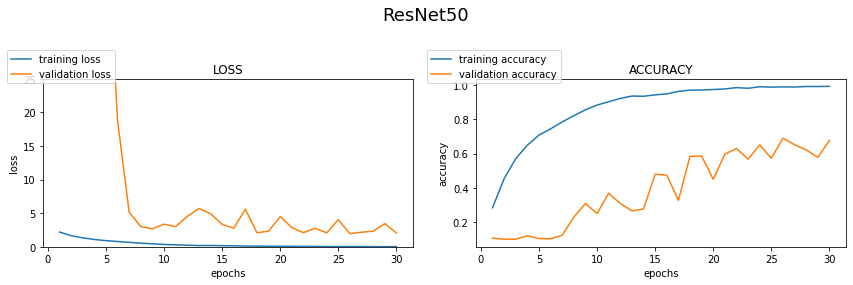

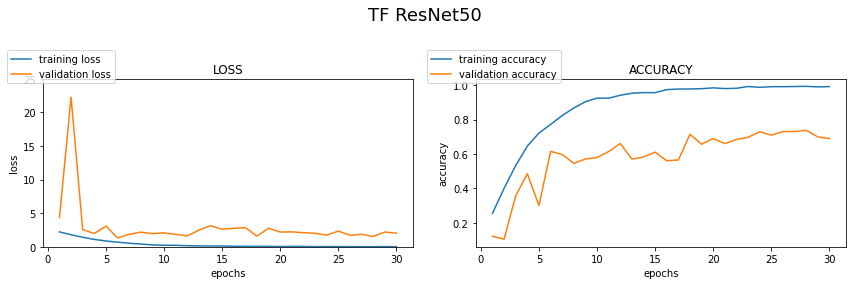

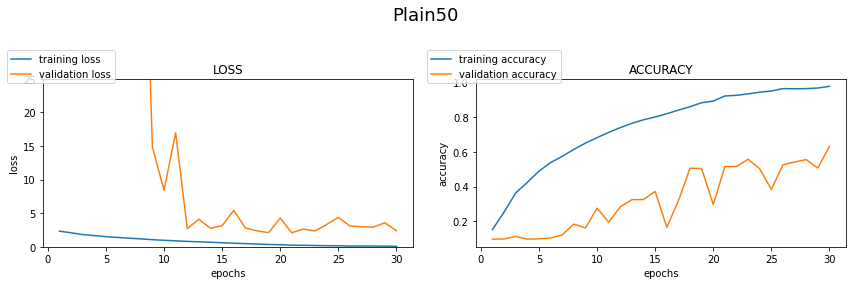

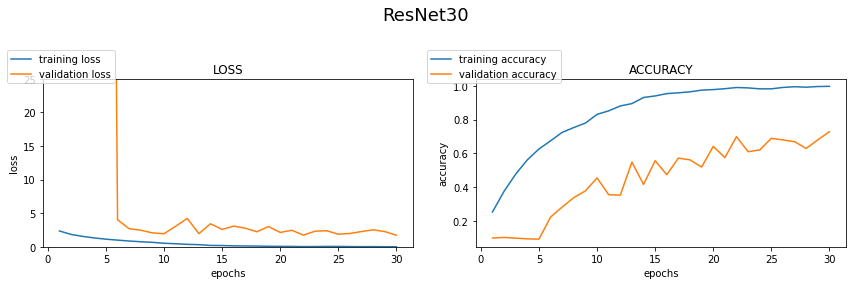

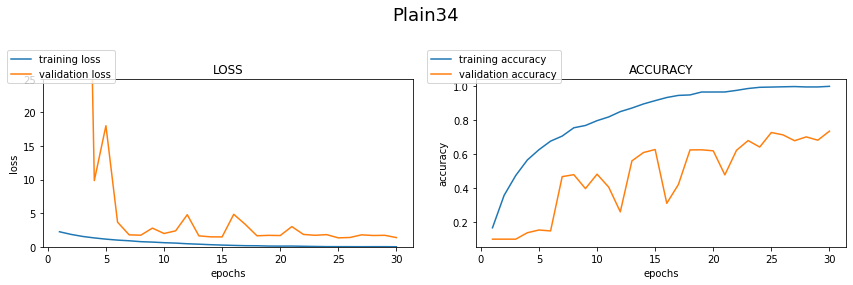

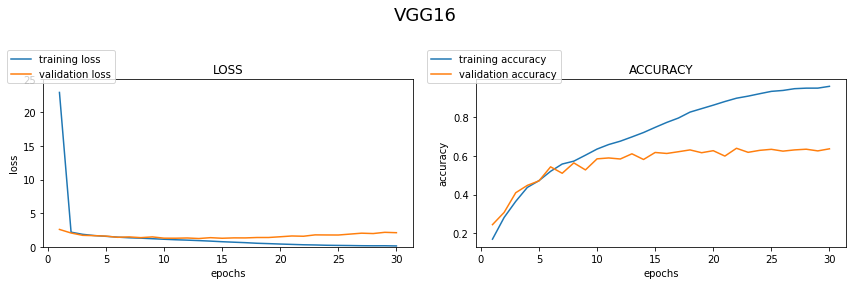

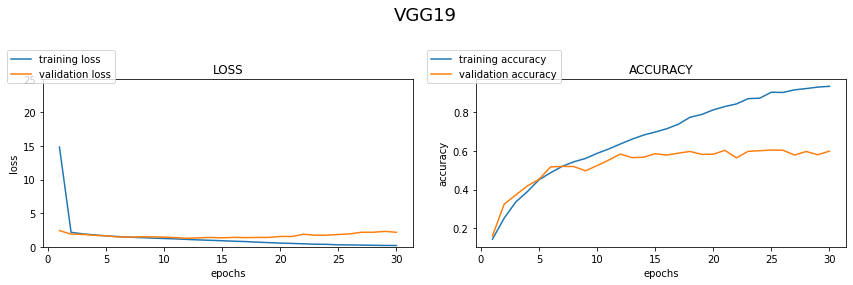

In [131]:
for history in history_list:
    plot_history(history)

## Cifar-10 test

In [147]:
cifar10_history_list = [
    {"name":"ResNet26 Cifar10",
    "data":history_resnet_cifar_10},
    {"name":"VGG 16Layer",
     "data":history_vgg_16}, 
    {"name":"VGG 19Layer",
     "data": history_vgg_19}, ]

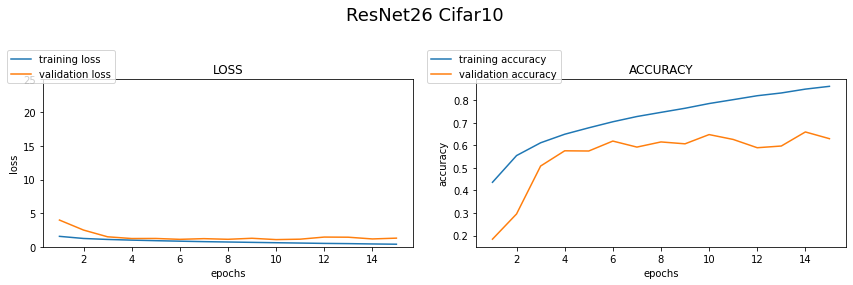

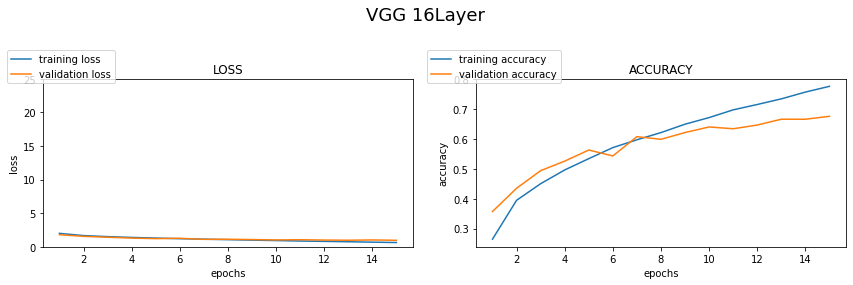

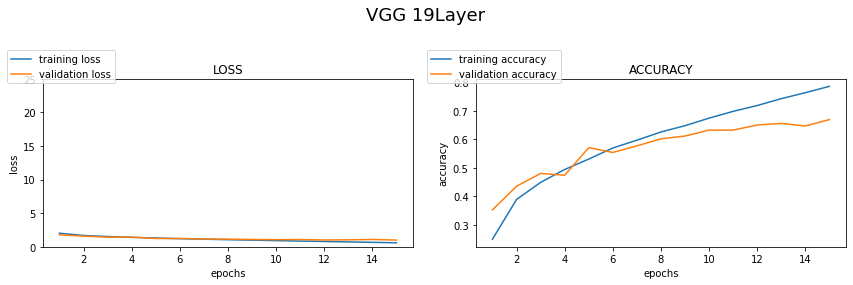

In [148]:
for cifar_history in cifar10_history_list:
    plot_history(cifar_history)

# 7.결론

1. 깊은 레이어를 다루기 위해서는 여러가지 테크닉이 필요하다.
2. 레이어가 깊다고 꼭 좋은것은 아니다.
3. 파라미터가 크다고 꼭 좋은것은 아니지만 파라미터가 크면 좋은 모델이 될 확율이 높은것 같다.
4. ResNet 중간에 MaxPooling 레이어를 한번 넣어봤으면 어떨까 싶다.
5. ResNet의 개념이 RNN과 비슷하다는 생각을 했다.
6. 새로운 모델을 개발하는 일은 Augmentation보다 더 많은 돈과 노동력이 든다.
7. 모델도 중요하지만 데이터가 더 중요한거 같다.